
PROBLEM 2 Parametric Representation of 3D Propeller Blade Geometry

QUESTION #1

Description of the camber as a reversible transformation

In [114]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from scipy.interpolate import CubicSpline

In [115]:
#blade parameters

mm = 0.29             # max blade half width
pp = 0.3              # x-coordinate of point in the mean curve giving the max blade half width
rr = 0.1              # leading edge radius
tt = np.sqrt(rr)/1.1

In [116]:
# y-coordinate of points in the mean curve as a function of the x-coordinate

def yycc(x,m,p):

    out = m *(2*p*x -x**2)/p**2
    if (x > p):
        out = m*(1 -2*p +2*p*x-x**2)/(1-p)**2
    return out

In [117]:
npts = 100
#xx = np.linspace(0,1,npts)
xx = np.linspace(0.001, 1, npts)
yy = np.array([yycc(u,mm,pp) for u in xx])

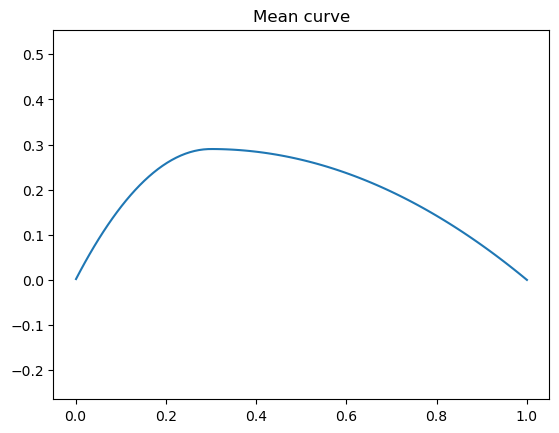

In [118]:
plt.axis('equal')
plt.title('Mean curve')
plt.plot(xx,yy)

In [119]:
# derivative of the funtion giving the y-coord

def dyycc(x,m,p):

    out = m *(2*p -2*x)/p**2
    if (x > p):
        out = m*(2*p-2*x)/(1-p)**2
    return out

In [120]:
# half-width as a function of the

def width(x,t):
  out = t *(0.2969*np.sqrt(x)-0.1260 *x -0.3516 * x**2 + 0.2843 * x**3 -0.10150 * x**4)/0.20
  return out

In [121]:
largura = np.array([width(u,tt) for u in xx])

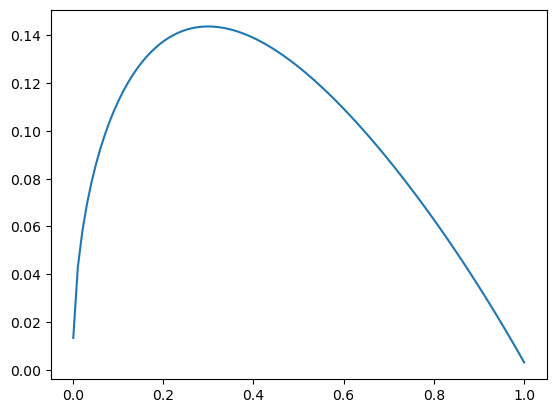

In [122]:
plt.plot(xx,largura)

In [123]:
def varphi(x,m,p):
  out = np.arctan2(dyycc(x,m,p),1)
  return out

In [124]:
angulos = np.array([varphi(u,mm,pp) for u in xx])

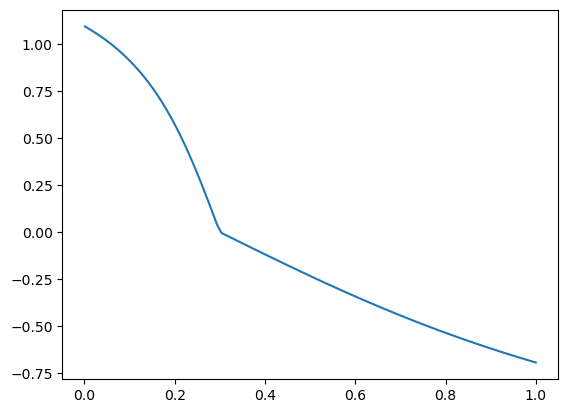

In [125]:
plt.plot(xx,angulos)

In [126]:
def xxuu(x,m,p,t):
  out = x - width(x,t) * np.sin(varphi(x,m,p))
  return out

def yyuu(x,m,p,t):
  out = yycc(x,m,p) + width(x,t) * np.cos(varphi(x,m,p))
  return out

def xxll(x,m,p,t):
  out = x + width(x,t) * np.sin(varphi(x,m,p))
  return out

def yyll(x,m,p,t):
  out = yycc(x,m,p) - width(x,t) * np.cos(varphi(x,m,p))
  return out


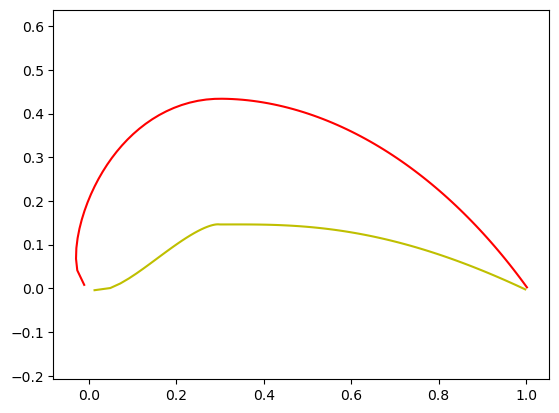

In [127]:
XU = np.array([xxuu(u,mm,pp,tt) for u in xx])
YU = np.array([yyuu(u,mm,pp,tt) for u in xx])
XL = np.array([xxll(u,mm,pp,tt) for u in xx])
YL = np.array([yyll(u,mm,pp,tt) for u in xx])

plt.axis('equal')
plt.plot(XU,YU,'r')
plt.plot(XL,YL,'y')

In [135]:
# Training Data (20 points per surface) ---
ixs = np.linspace(0, len(XU) - 1, 20, dtype=int)
XU_train, YU_train = XU[ixs].reshape(-1,1), YU[ixs].reshape(-1,1)
XL_train, YL_train = XL[ixs].reshape(-1,1), YL[ixs].reshape(-1,1)

In [136]:
# Normalize inputs and outputs
x_scaler_u = MinMaxScaler().fit(XU_train)
y_scaler_u = MinMaxScaler().fit(YU_train)
x_scaler_l = MinMaxScaler().fit(XL_train)
y_scaler_l = MinMaxScaler().fit(YL_train)

Xu_n = torch.tensor(x_scaler_u.transform(XU_train), dtype=torch.float32)
Yu_n = torch.tensor(y_scaler_u.transform(YU_train), dtype=torch.float32)
Xl_n = torch.tensor(x_scaler_l.transform(XL_train), dtype=torch.float32)
Yl_n = torch.tensor(y_scaler_l.transform(YL_train), dtype=torch.float32)

In [137]:
# Define MLP Model
class CurveNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        return self.net(x)

model_u = CurveNet()
model_l = CurveNet()
opt_u = optim.Adam(model_u.parameters(), lr=0.01)
opt_l = optim.Adam(model_l.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

In [138]:
# Training Loop
for epoch in range(1000):
    # Upper curve
    opt_u.zero_grad()
    loss_u = loss_fn(model_u(Xu_n), Yu_n)
    loss_u.backward()
    opt_u.step()
    scheduler_u.step()

    # Lower c
    opt_l.zero_grad()
    loss_l = loss_fn(model_l(Xl_n), Yl_n)
    loss_l.backward()
    opt_l.step()
    scheduler_l.step()

In [139]:
# Prediction over full curve
xup = torch.tensor(x_scaler_u.transform(XU.reshape(-1,1)), dtype=torch.float32)
xlp = torch.tensor(x_scaler_l.transform(XL.reshape(-1,1)), dtype=torch.float32)

yup_pred = y_scaler_u.inverse_transform(model_u(xup).detach().numpy())
ylp_pred = y_scaler_l.inverse_transform(model_l(xlp).detach().numpy())

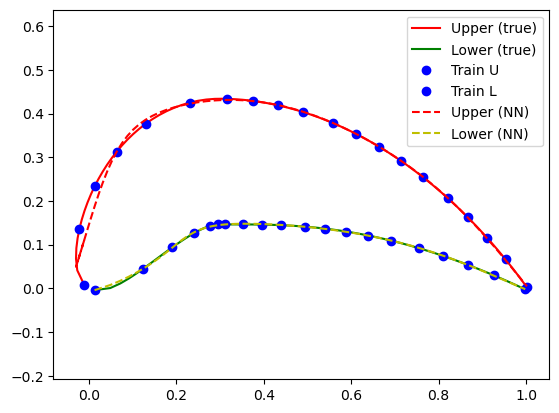

In [140]:
# Plots | Graphs
plt.axis('equal')
plt.plot(XU, YU
         , 'r-', label="Upper (true)")
plt.plot(XL, YL, 'g-', label="Lower (true)")
plt.plot(XU[ixs], YU[ixs], 'bo', label="Train U")
plt.plot(XL[ixs], YL[ixs], 'bo', label="Train L")
plt.plot(XU, yup_pred, 'r--', label="Upper (NN)")
plt.plot(XL, ylp_pred, 'y--', label="Lower (NN)")
plt.legend()
plt.show()

In [141]:
# Step 1: Define spanwise positions and corresponding parameter values
z_nodes = np.array([0.0, 0.25, 0.5, 0.75, 1.0])  # span from root to tip

In [142]:
# Airfoil parameters as functions of z
p_vals = np.array([0.4, 0.42, 0.38, 0.35, 0.3])         # max camber position
m_vals = np.array([0.02, 0.025, 0.03, 0.035, 0.04])      # max camber
LER_vals = np.array([0.01, 0.015, 0.018, 0.015, 0.01])   # leading edge radius
TE_vals = np.array([0.002, 0.0025, 0.003, 0.0025, 0.002])# trailing edge thickness
c_vals = np.array([1.0, 0.9, 0.8, 0.6, 0.4])             # chord length

In [148]:
# Step 2: Create cubic spline interpolations
p_spline = CubicSpline(z_nodes, p_vals)
m_spline = CubicSpline(z_nodes, m_vals)
LER_spline = CubicSpline(z_nodes, LER_vals)
TE_spline = CubicSpline(z_nodes, TE_vals)
c_spline = CubicSpline(z_nodes, c_vals)

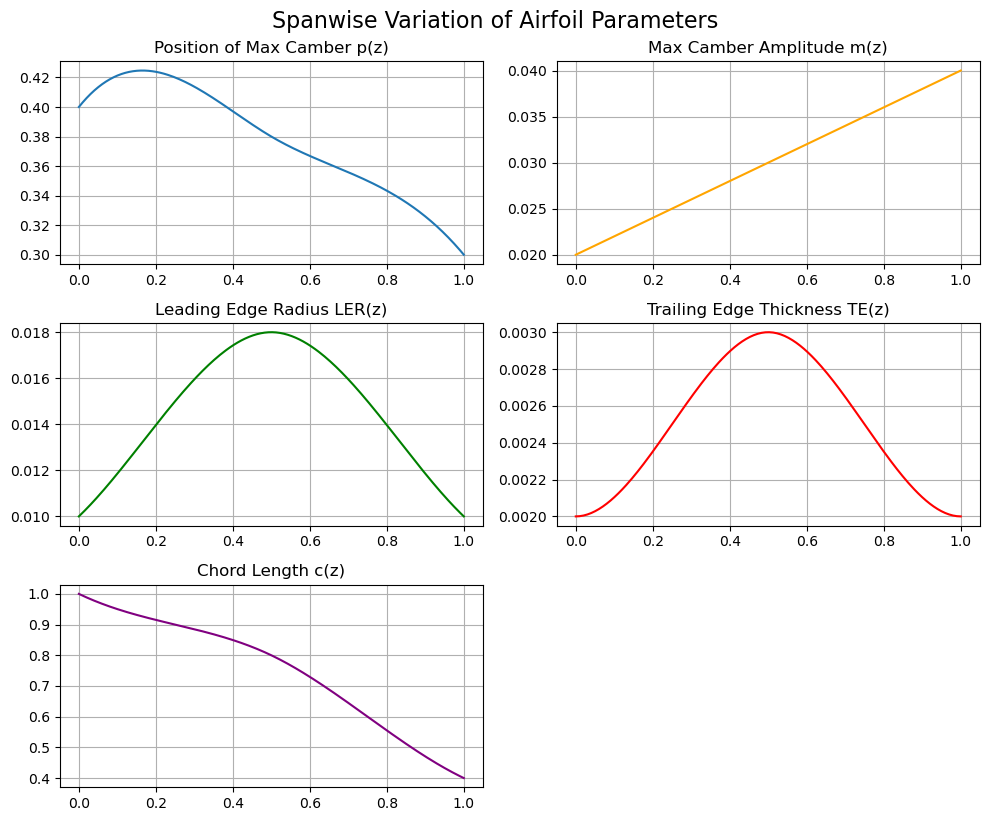

In [153]:
# Step 3: Plot spanwise parameter variations
z_dense = np.linspace(0, 1, 200)

plt.figure(figsize=(10, 8))
plt.subplot(3, 2, 1)
plt.plot(z_dense, p_spline(z_dense))
plt.title("Position of Max Camber p(z)")
plt.grid(True)

plt.subplot(3, 2, 2)
plt.plot(z_dense, m_spline(z_dense), color='orange')
plt.title("Max Camber Amplitude m(z)")
plt.grid(True)

plt.subplot(3, 2, 3)
plt.plot(z_dense, LER_spline(z_dense), color='green')
plt.title("Leading Edge Radius LER(z)")
plt.grid(True)

plt.subplot(3, 2, 4)
plt.plot(z_dense, TE_spline(z_dense), color='red')
plt.title("Trailing Edge Thickness TE(z)")
plt.grid(True)

plt.subplot(3, 2, 5)
plt.plot(z_dense, c_spline(z_dense), color='purple')
plt.title("Chord Length c(z)")
plt.grid(True)

plt.tight_layout()
plt.suptitle("Spanwise Variation of Airfoil Parameters", fontsize=16, y=1.02)
plt.show()


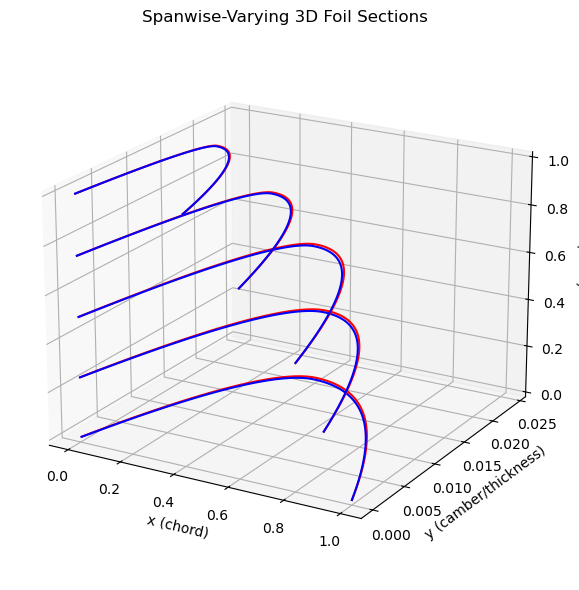

In [154]:
# Step 4: Define helper functions for 2D airfoil generation using z-dependent parameters

def camber_line(x, m, p):
    """Mean camber line"""
    return np.where(x <= p,
                    m * (2 * p * x - x ** 2) / p ** 2,
                    m * (1 - 2 * p + 2 * p * x - x ** 2) / (1 - p) ** 2)

def dcamber_line(x, m, p):
    """Derivative of camber line"""
    return np.where(x <= p,
                    2 * m * (p - x) / p ** 2,
                    2 * m * (p - x) / (1 - p) ** 2)

def thickness_dist(x, t):
    """Thickness distribution from NACA 4-digit"""
    return t * (0.2969 * np.sqrt(x) - 0.1260 * x - 0.3516 * x ** 2 +
                0.2843 * x ** 3 - 0.1015 * x ** 4)

def airfoil_section(x, m, p, t):
    """Compute upper and lower surface coordinates"""
    yt = thickness_dist(x, t)
    yc = camber_line(x, m, p)
    dyc = dcamber_line(x, m, p)
    theta = np.arctan(dyc)

    xu = x - yt * np.sin(theta)
    yu = yc + yt * np.cos(theta)
    xl = x + yt * np.sin(theta)
    yl = yc - yt * np.cos(theta)

    return xu, yu, xl, yl

# Step 5: Generate several 2D airfoil sections at different spanwise positions z
spanwise_z = np.linspace(0, 1, 5)
sections = []
x_vals = np.linspace(0.001, 1, 100)

for z in spanwise_z:
    p = p_spline(z)
    m = m_spline(z)
    t = TE_spline(z)
    c = c_spline(z)
    
    xu, yu, xl, yl = airfoil_section(x_vals, m, p, t)
    
    # Scale by chord and embed in 3D (x, y, z)
    x_upper = c * xu
    y_upper = yu * c
    z_upper = np.full_like(x_upper, z)

    x_lower = c * xl
    y_lower = yl * c
    z_lower = np.full_like(x_lower, z)

    sections.append(((x_upper, y_upper, z_upper), (x_lower, y_lower, z_lower)))

# Step 6: Plot multiple sections in 3D
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

for (x_u, y_u, z_u), (x_l, y_l, z_l) in sections:
    ax.plot(x_u, y_u, z_u, 'r')
    ax.plot(x_l, y_l, z_l, 'b')

ax.set_title("Spanwise-Varying 3D Foil Sections")
ax.set_xlabel("x (chord)")
ax.set_ylabel("y (camber/thickness)")
ax.set_zlabel("z (span)")
ax.view_init(elev=20, azim=-60)
plt.tight_layout()
plt.show()
